In [0]:
import numpy as np


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [0]:
CUDA = True
BATCH_SIZE = 64

In [0]:
# Define Train loader
train_tensors = 2*((original_train_dataset.data.float() / 255)-0.5)
test_tensors = 2*((original_test_dataset.data.float() / 255)-0.5)

train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [181]:
class Flatten(nn.Module):
  def forward(self, input):
#     print(input.size(0))
    return input.view(input.size(0), -1)

discriminator = nn.Sequential(
    nn.Dropout(),
    nn.Conv2d(1, 128, 2, stride=2),
    nn.LeakyReLU(0.2),
    nn.Conv2d(128, 256, 3, stride=2),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    nn.Conv2d(256, 512, 3, stride=1),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2),
    nn.Conv2d(512, 1024, 3, stride=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2),
    Flatten(),
    nn.Linear(4096, 1),
    nn.Sigmoid()
)
print(discriminator(torch.randn(10,1,28,28)).shape)

torch.Size([10, 1])


In [182]:
generator = nn.Sequential(
    nn.ConvTranspose2d(128, 1024, 3, stride=1),
    nn.BatchNorm2d(1024),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(1024, 512, 3, stride=3),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(512, 256, 3, stride=3),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(256, 128, 2, stride=1),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2),
    nn.ConvTranspose2d(128, 1, 1, stride=1),
    nn.Tanh()
    
    
)
zz = torch.randn(1,128,1,1)
print(generator(zz).shape)

torch.Size([1, 1, 28, 28])


In [0]:
if CUDA:
  discriminator.cuda()
  generator.cuda()

In [0]:
LEARNING_RATE_D = 0.0002
LEARNING_RATE_G = 0.0002


opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

In [0]:
N_EPOCH = 20

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3) # set default size of plots

epoch: 0 	 last batch loss D: 0.001165817491710186 	 last batch loss G: 0.008741399273276329


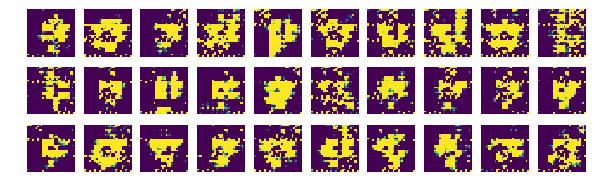

epoch: 1 	 last batch loss D: 0.13157902657985687 	 last batch loss G: 1.612831473350525


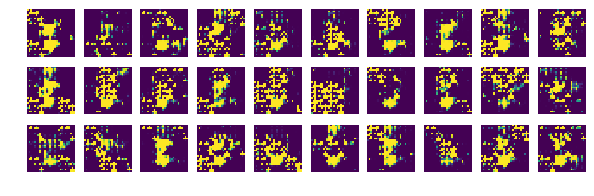

epoch: 2 	 last batch loss D: 0.9726872444152832 	 last batch loss G: 2.7723259925842285


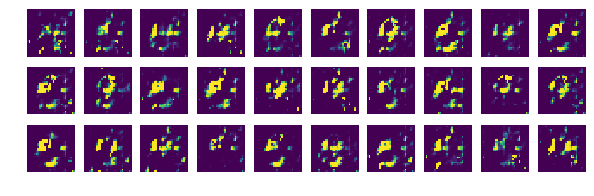

epoch: 3 	 last batch loss D: 0.26019302010536194 	 last batch loss G: 5.86395263671875


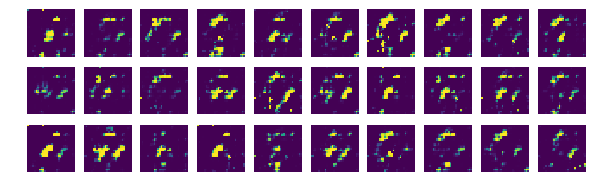

epoch: 4 	 last batch loss D: 0.9812838435173035 	 last batch loss G: 0.4443739354610443


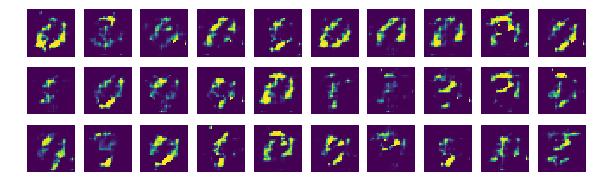

epoch: 5 	 last batch loss D: 0.06584078073501587 	 last batch loss G: 0.4006505012512207


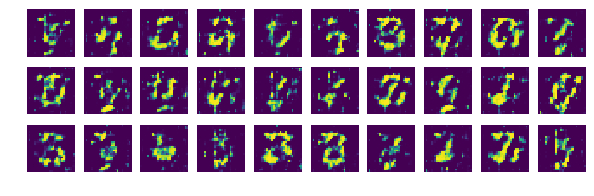

epoch: 6 	 last batch loss D: 0.1648169308900833 	 last batch loss G: 0.6549074053764343


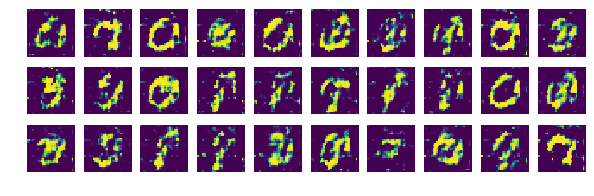

epoch: 7 	 last batch loss D: 0.16602464020252228 	 last batch loss G: 0.3618168234825134


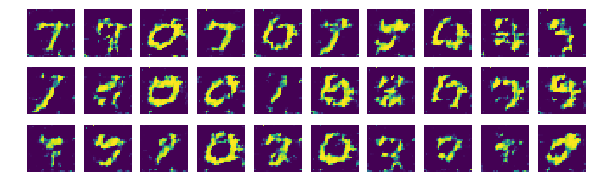

epoch: 8 	 last batch loss D: 0.3608894348144531 	 last batch loss G: 2.3171029090881348


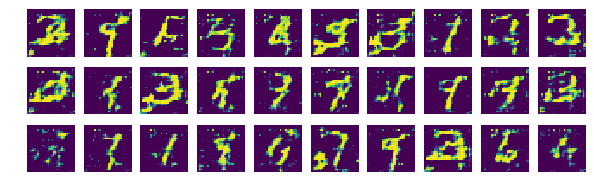

epoch: 9 	 last batch loss D: 0.23659363389015198 	 last batch loss G: 1.380445957183838


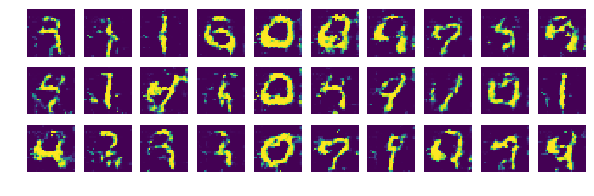

epoch: 10 	 last batch loss D: 0.13979752361774445 	 last batch loss G: 2.520747423171997


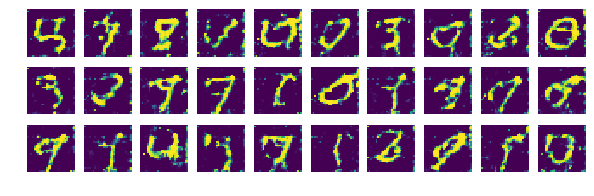

epoch: 11 	 last batch loss D: 0.41170358657836914 	 last batch loss G: 1.6126129627227783


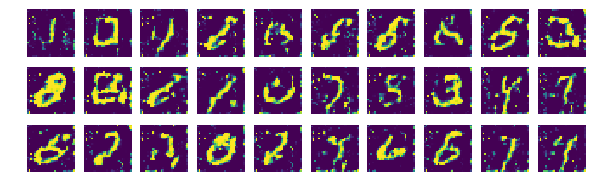

epoch: 12 	 last batch loss D: 0.5120384097099304 	 last batch loss G: 1.4414801597595215


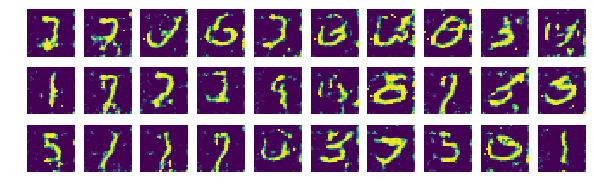

epoch: 13 	 last batch loss D: 0.353517085313797 	 last batch loss G: 0.44066861271858215


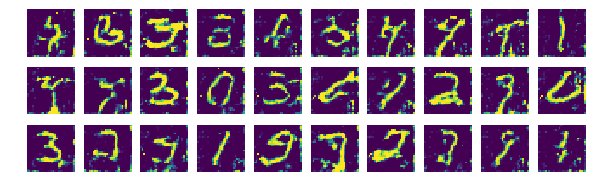

epoch: 14 	 last batch loss D: 0.02068326063454151 	 last batch loss G: 0.1201271340250969


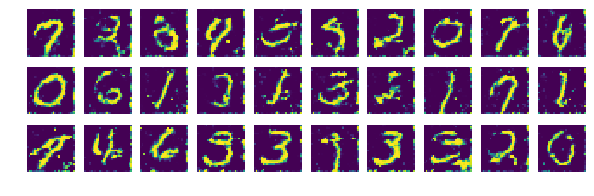

epoch: 15 	 last batch loss D: 0.2714362144470215 	 last batch loss G: 0.10439836233854294


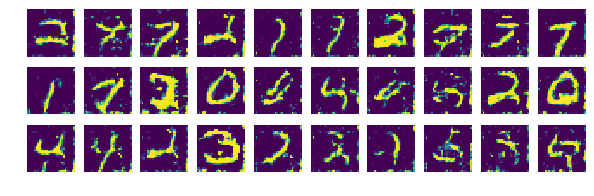

epoch: 16 	 last batch loss D: 0.06658092886209488 	 last batch loss G: 0.09837685525417328


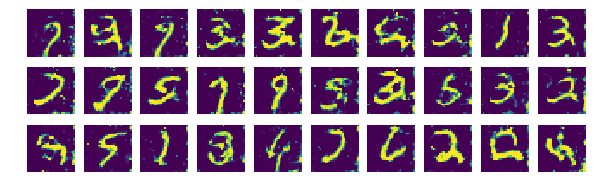

epoch: 17 	 last batch loss D: 0.08951491117477417 	 last batch loss G: 1.492773413658142


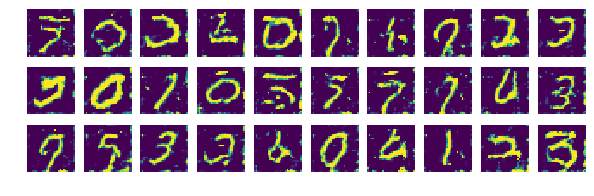

epoch: 18 	 last batch loss D: 0.02039153128862381 	 last batch loss G: 0.000464066892163828


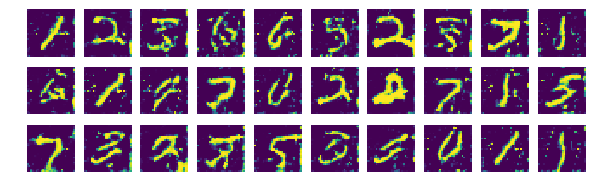

epoch: 19 	 last batch loss D: 0.028414292261004448 	 last batch loss G: 0.3700777292251587


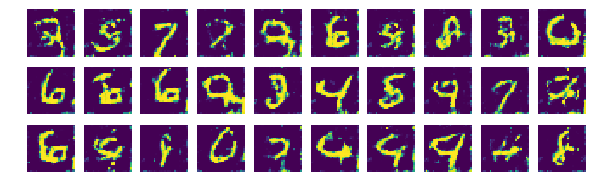

In [185]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)
        img = img.view(-1, 1, 28, 28)
#         print(img.shape)
        
        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128, 1, 1)
        if CUDA:
            z = z.cuda()
        fake_img = generator(z).view(-1, 1, 28, 28)
#         discriminator(fake_img)
#         print(fake_img.shape)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.randn(img.shape[0], 128, 1, 1)
        if CUDA:
          z = z.cuda()
        fake_img = generator(z).view(-1, 1, 28, 28)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################

    
    print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

    # [CHANGED] Better output
    for i in range(3):
        for j in range(10):
            plt.subplot(3, 10, i * 10 + j + 1)
            plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy(), vmin=-1, vmax=1)
            plt.axis("off")
    plt.show()


epoch: 0 	 last batch loss D: 0.06294818222522736 	 last batch loss G: 1.1504004001617432


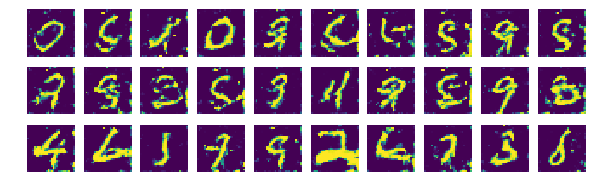

epoch: 1 	 last batch loss D: 0.3531433045864105 	 last batch loss G: 0.3264131546020508


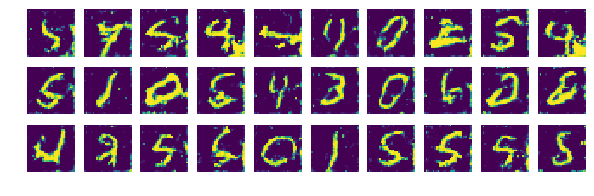

epoch: 2 	 last batch loss D: 0.034234773367643356 	 last batch loss G: 3.3201749324798584


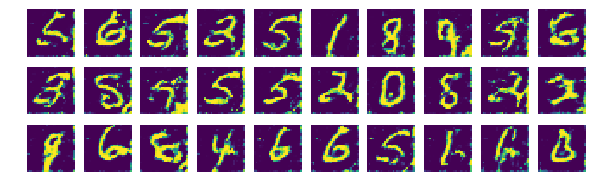

epoch: 3 	 last batch loss D: 0.17174135148525238 	 last batch loss G: 1.3556315898895264


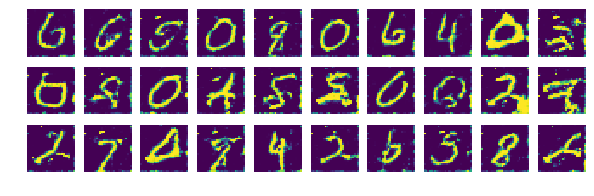

epoch: 4 	 last batch loss D: 0.5226669311523438 	 last batch loss G: 1.3407084941864014


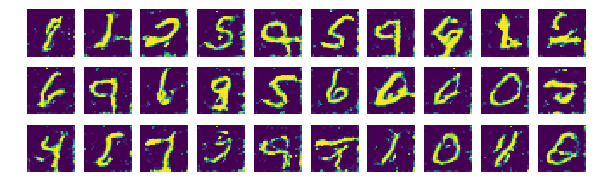

epoch: 5 	 last batch loss D: 0.2648613154888153 	 last batch loss G: 0.03855098783969879


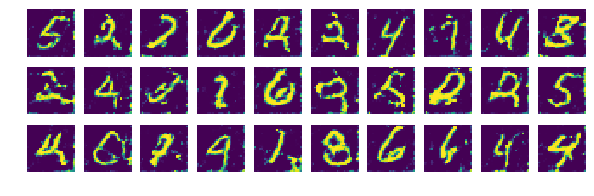

epoch: 6 	 last batch loss D: 1.7348781824111938 	 last batch loss G: 0.6964343786239624


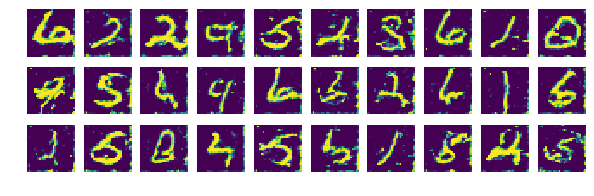

epoch: 7 	 last batch loss D: 0.052989162504673004 	 last batch loss G: 0.11704778671264648


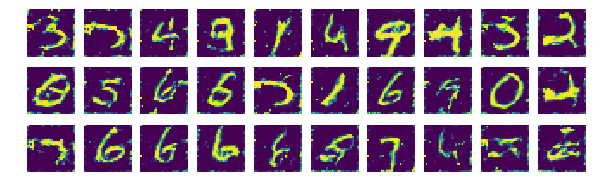

epoch: 8 	 last batch loss D: 0.1638135462999344 	 last batch loss G: 0.2506542503833771


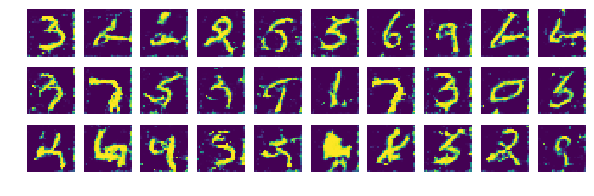

epoch: 9 	 last batch loss D: 0.026305261999368668 	 last batch loss G: 0.24460765719413757


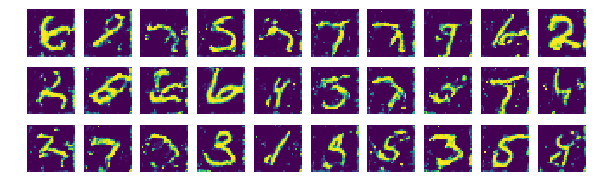

epoch: 10 	 last batch loss D: 0.12687252461910248 	 last batch loss G: 0.24460460245609283


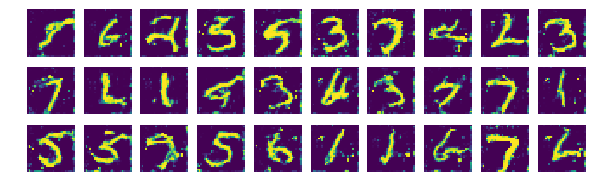

epoch: 11 	 last batch loss D: 0.008841541595757008 	 last batch loss G: 3.0205132961273193


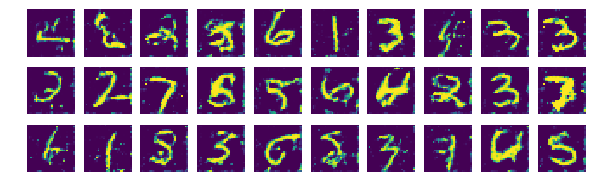

epoch: 12 	 last batch loss D: 0.27865734696388245 	 last batch loss G: 0.01558698620647192


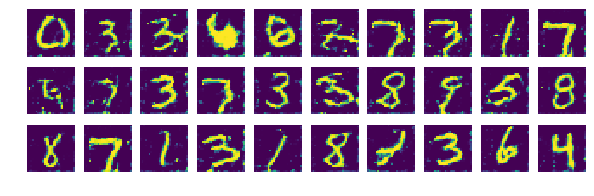

epoch: 13 	 last batch loss D: 0.0069717587903141975 	 last batch loss G: 0.007782687433063984


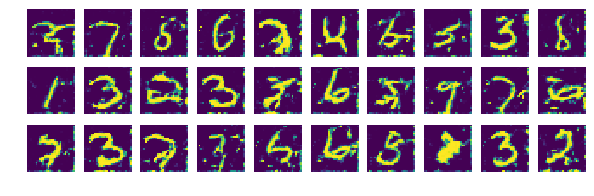

epoch: 14 	 last batch loss D: 0.025777194648981094 	 last batch loss G: 0.10051025450229645


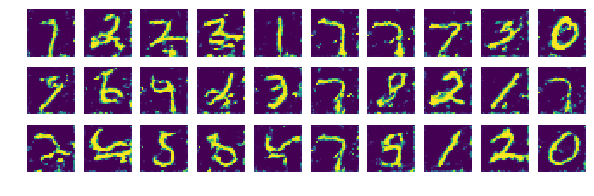

epoch: 15 	 last batch loss D: 0.059334658086299896 	 last batch loss G: 0.09154185652732849


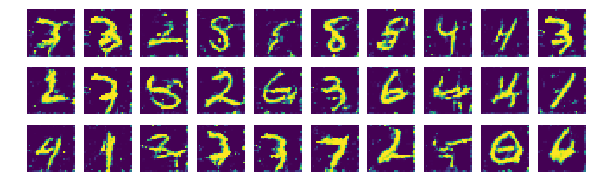

epoch: 16 	 last batch loss D: 0.1393875926733017 	 last batch loss G: 1.2158002853393555


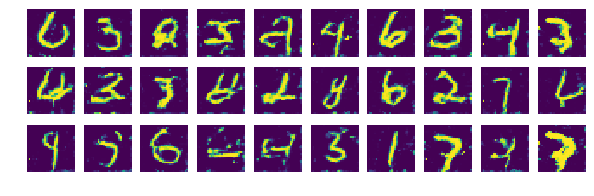

epoch: 17 	 last batch loss D: 0.0011797357583418489 	 last batch loss G: 0.22641173005104065


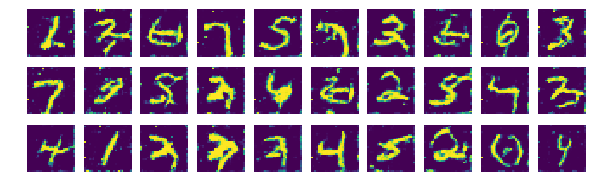

epoch: 18 	 last batch loss D: 0.0025709280744194984 	 last batch loss G: 0.0261707566678524


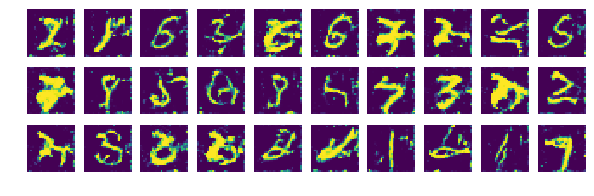

epoch: 19 	 last batch loss D: 0.001181937986984849 	 last batch loss G: 0.20251339673995972


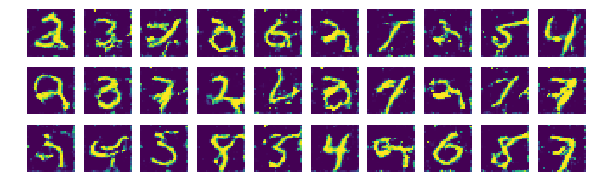

In [186]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)
        img = img.view(-1, 1, 28, 28)
#         print(img.shape)
        
        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128, 1, 1)
        if CUDA:
            z = z.cuda()
        fake_img = generator(z).view(-1, 1, 28, 28)
#         discriminator(fake_img)
#         print(fake_img.shape)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.randn(img.shape[0], 128, 1, 1)
        if CUDA:
          z = z.cuda()
        fake_img = generator(z).view(-1, 1, 28, 28)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################

    
    print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

    # [CHANGED] Better output
    for i in range(3):
        for j in range(10):
            plt.subplot(3, 10, i * 10 + j + 1)
            plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy(), vmin=-1, vmax=1)
            plt.axis("off")
    plt.show()


In [0]:
saved_d = discriminator
saved_g = generator

epoch: 0 	 last batch loss D: 0.0021570471581071615 	 last batch loss G: 0.00218821014277637


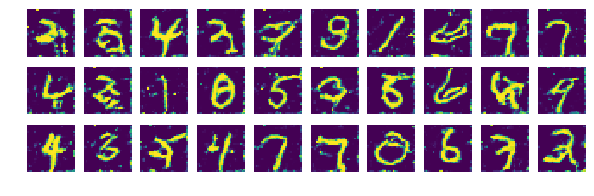

epoch: 1 	 last batch loss D: 0.28175419569015503 	 last batch loss G: 0.9664793610572815


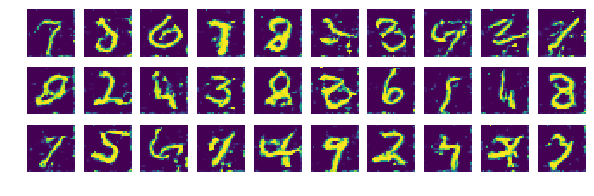

epoch: 2 	 last batch loss D: 1.3026337623596191 	 last batch loss G: 0.009350440464913845


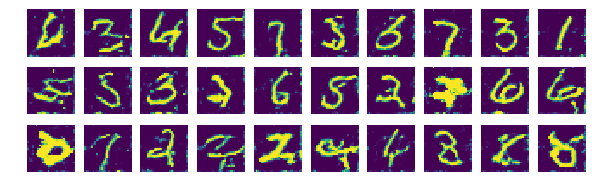

epoch: 3 	 last batch loss D: 0.061645835638046265 	 last batch loss G: 0.055862199515104294


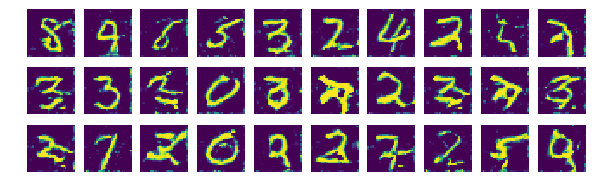

epoch: 4 	 last batch loss D: 0.4294861853122711 	 last batch loss G: 0.060758352279663086


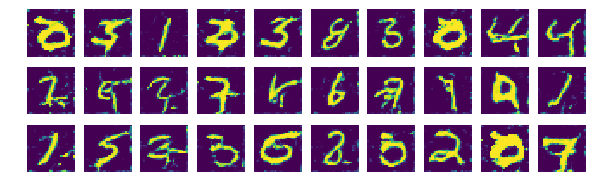

epoch: 5 	 last batch loss D: 0.6251184940338135 	 last batch loss G: 0.1610134392976761


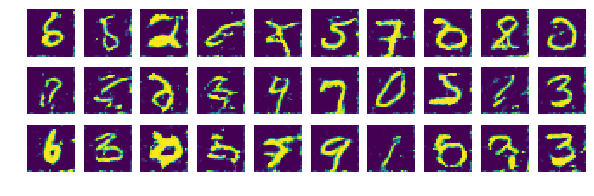

epoch: 6 	 last batch loss D: 0.0079328753054142 	 last batch loss G: 0.26117557287216187


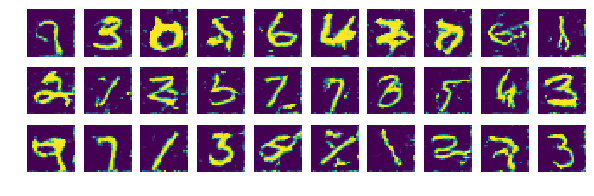

epoch: 7 	 last batch loss D: 0.024448681622743607 	 last batch loss G: 0.09378355741500854


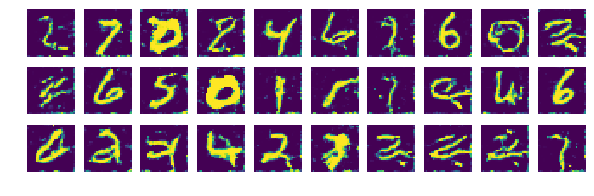

epoch: 8 	 last batch loss D: 0.014747589826583862 	 last batch loss G: 0.08324506133794785


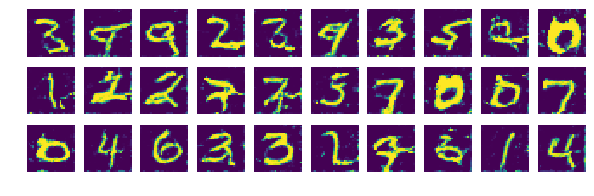

epoch: 9 	 last batch loss D: 0.21850326657295227 	 last batch loss G: 0.020122908055782318


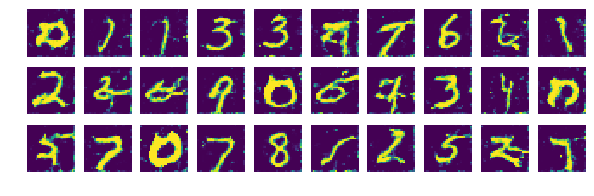

epoch: 10 	 last batch loss D: 0.021809646859765053 	 last batch loss G: 1.083472490310669


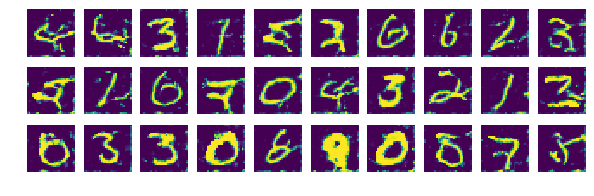

epoch: 11 	 last batch loss D: 0.02893058769404888 	 last batch loss G: 0.020464584231376648


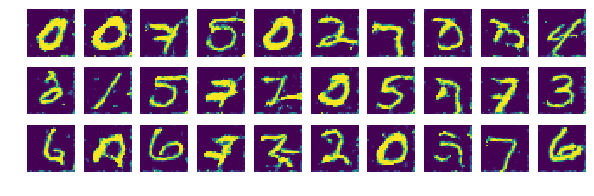

epoch: 12 	 last batch loss D: 0.016910415142774582 	 last batch loss G: 0.1032506674528122


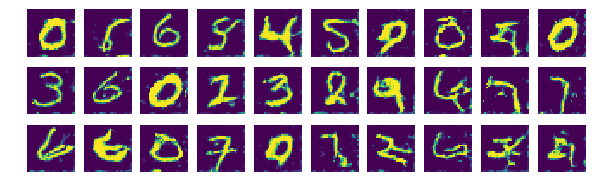

epoch: 13 	 last batch loss D: 0.012679451145231724 	 last batch loss G: 0.12536528706550598


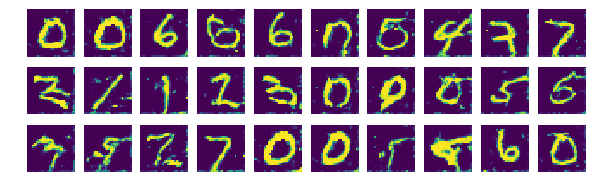

epoch: 14 	 last batch loss D: 0.26901277899742126 	 last batch loss G: 0.009960204362869263


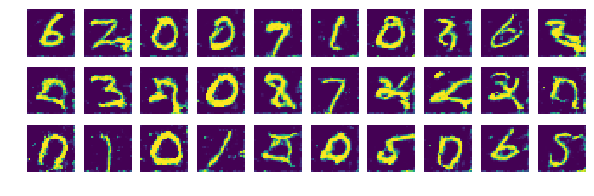

epoch: 15 	 last batch loss D: 0.025414181873202324 	 last batch loss G: 0.005045134574174881


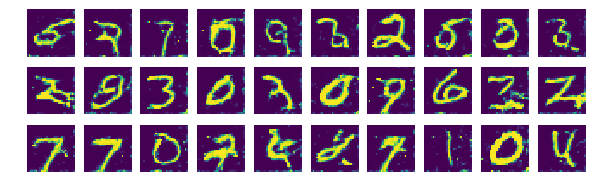

epoch: 16 	 last batch loss D: 0.01825951784849167 	 last batch loss G: 0.5840743780136108


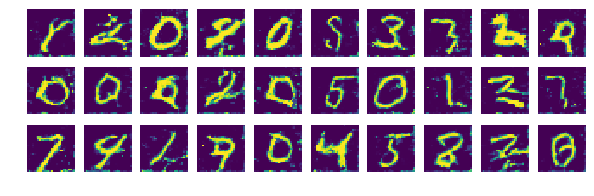

epoch: 17 	 last batch loss D: 0.014959470368921757 	 last batch loss G: 0.030677488073706627


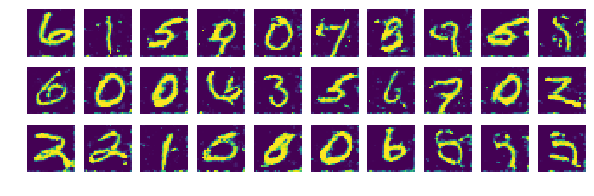

epoch: 18 	 last batch loss D: 0.001602349802851677 	 last batch loss G: 0.015744417905807495


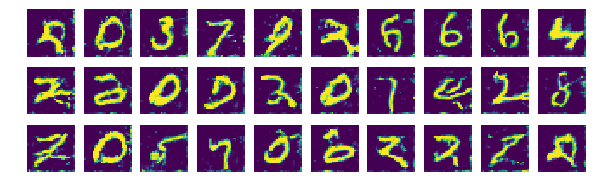

epoch: 19 	 last batch loss D: 0.001626444049179554 	 last batch loss G: 0.0031898836605250835


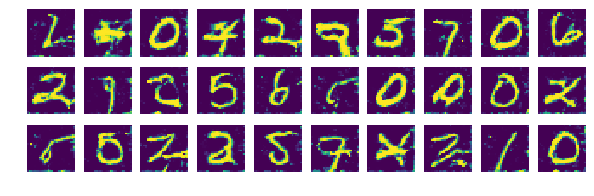

In [189]:
# [CHANGED] EPSILON is not needed anymore
# EPSILON = 1e-6
LEARNING_RATE_D = 0.00005
LEARNING_RATE_G = 0.00005


opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim=1)
        img = img.view(-1, 1, 28, 28)
#         print(img.shape)
        
        real_img = img
        if CUDA:
            real_img = real_img.cuda()

        fake_labels = torch.zeros(img.shape[0], 1).cuda()
        real_labels = torch.ones(img.shape[0], 1).cuda()

        #########################
        z = torch.rand(img.shape[0], 128, 1, 1)
        if CUDA:
            z = z.cuda()
        fake_img = generator(z).view(-1, 1, 28, 28)
#         discriminator(fake_img)
#         print(fake_img.shape)

        opt_D.zero_grad()
        # [CHANGED] BCE is more stable
        #         loss_d = -(torch.log(EPSILON + 1 - discriminator(fake_img.detach())) + 
        #                    torch.log(EPSILON + discriminator(real_img))).mean()
        loss_d = (F.binary_cross_entropy(discriminator(fake_img.detach()), fake_labels) +
                  F.binary_cross_entropy(discriminator(real_img), real_labels))
        loss_d.backward()
        opt_D.step()
        #########################
        z = torch.randn(img.shape[0], 128, 1, 1)
        if CUDA:
          z = z.cuda()
        fake_img = generator(z).view(-1, 1, 28, 28)

        opt_G.zero_grad()
        # [CHANGED] BCE is more stable
        #     loss_g = - torch.log(EPSILON + discriminator(fake_img)).mean()
        loss_g = F.binary_cross_entropy(discriminator(fake_img), real_labels)
        loss_g.backward()
        opt_G.step()
        #########################

    
    print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))

    # [CHANGED] Better output
    for i in range(3):
        for j in range(10):
            plt.subplot(3, 10, i * 10 + j + 1)
            plt.imshow(fake_img[i * 10 + j].detach().cpu().view(28, 28).numpy(), vmin=-1, vmax=1)
            plt.axis("off")
    plt.show()
